In [1]:
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit,compile, execute,IBMQ
from qiskit import BasicAer
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from math import pi
from qiskit.mapper._layout import Layout as Ibmlayout
from qiskit.tools.compiler import compile as qcompile
import matplotlib.pyplot as plt
import sys
from qiskit.tools.visualization import circuit_drawer
from parseRealization import *
from copy import deepcopy
%matplotlib inline
testDir="./tests/"

C:\Users\krylo\Anaconda3\lib\site-packages\marshmallow\schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [2]:
#select a backend
IBMQ.load_accounts()
backends = IBMQ.backends(simulator=False,filters=lambda x: x.configuration().n_qubits > 4)
print(backends)
#print(available)
#least_busy = BasicAer.get_backend('qasm_simulator')
least_busy = IBMQ.get_backend('ibmq_16_melbourne')
couplingMap = least_busy.configuration().coupling_map
print(couplingMap,"its length:",len(couplingMap))
qubitsSize = least_busy.configuration().n_qubits


[<IBMQBackend('ibmqx4') from IBMQ()>, <IBMQBackend('ibmq_16_melbourne') from IBMQ()>]
[[1, 0], [1, 2], [2, 3], [4, 3], [4, 10], [5, 4], [5, 6], [5, 9], [6, 8], [7, 8], [9, 8], [9, 10], [11, 3], [11, 10], [11, 12], [12, 2], [13, 1], [13, 12]] its length: 18


In [3]:
def prepareIBMQLayout(qReg,layout):
    ibmLayout = {}
    for elem in layout:
       # print("Element in layout is",elem," physical is",layout[elem])
        quantum = ord(elem)-ord("a")
        physical = ord(layout[elem])-ord("a")
        quantumTuple = (qReg.name, quantum)
        ibmLayout[quantumTuple]=(qReg.name,physical)
    #print("tempDictionary",ibmLayout)
    #print("items are",ibmLayout.items())
    #print("IBMLAYOUT")
    #print(ibmLayout)
    return ibmLayout

def bigFunction(fileName):
    ioClass = readCircuitInformation(fileName) 
    answers = ioClass.getKmap()
    size = ioClass.getSize()
    ioClass.readGatesFromFile(fileName)
    backend_sim = BasicAer.get_backend('qasm_simulator')
    error_count = 0
    
    ctg = CircuitTransitionGraph()
    tempStuff = ctg.transformCoupling(couplingMap)
    print(tempStuff,len(tempStuff))
    ctg.setSize(size)
    epoch = 0
    leastCost = 2000000
    defaultIBMCost = 100000
    finalAnswer = []
    finalLayout = []
    costHistory =[]
    ibmCostHistory = []
    for i in range(0,1):
        #This part corresponds for part of experiment without minimal or no changes
        while epoch < 10:
            print("Epoch number:",epoch)
            print("Current layout of ctg is:",ctg.layout)
            tempLayout = ctg.layout.copy()
            qr,cr,qc = ioClass.createCircuitAndSetInput(i)
            ibmLayout = prepareIBMQLayout(qr,tempLayout)
            qc,qr = ctg.readGatesFromIOClass(qr,qc, ioClass)
            if epoch==0:
                defaultIBMCost = measureFidelityWithoutChanges(qr,cr,qc)
            ctg = fixTheStuff(ctg)
            #This one needs to comply with changes you did
            #qc,qr = ctg.readFixedGatesFromCtg(qr,qc)
           
            qr,cr,qc = ioClass.createCircuitAndSetInput(i)
            qc,qr = ctg.readFixedGatesFromCtg(qr,qc)
            ibmLayout = prepareIBMQLayout(qr,tempLayout)
            tempCost = compileToSeeCost(qr,cr,qc,ioClass,ibmLayout,i)
            ibmCostHistory.append(tempCost)
            costHistory.append(len(ctg.lines))
            if tempCost < leastCost:
                finalAnswer = deepcopy(ctg.lines)
                finalLayout = deepcopy(tempLayout)
                leastCost = tempCost
            #measureToVerifyOutputWtihChanges(qr,cr,qc,ioClass,ibmLayout,i)
            ctg.layOutQubits()
            epoch = epoch+1
    for i in range(0,len(costHistory)):
        for j in range(0,len(costHistory)):
            if costHistory[i] < costHistory[j]:
                tempI = ibmCostHistory[j]
                temp = costHistory[j]
                costHistory[j]=costHistory[i]
                ibmCostHistory[j]=ibmCostHistory[i]
                costHistory[i] = temp
                ibmCostHistory[i] = tempI
    print("Default IBM cost is:",defaultIBMCost)
    print("FinalAnswer is:", finalAnswer)
    print("FinalAnswer finalLayout:", finalLayout)
    print("FinalAnswer cost is:",leastCost)
    print("CostHistory is:",costHistory)
    print("IBMCostHistory is:",ibmCostHistory)   
   
    plt.plot(ibmCostHistory,costHistory)

    
def fixTheStuff(ctg):
    print("Missing connections are",ctg.getMissingConnections())
    #This one to fix the changes... fixthemissingedges connects stuff around. did not test though
    ctg.fixMissingEdges()
    #print("FIxing the stuff")
    return ctg


def  compileToSeeCost(qr,cr,qc,ioClass,ibmLayout,i):
    #least_busy = BasicAer.get_backend('qasm_simulator')
    qc.measure(qr,cr)
    qobj = qcompile(qc,least_busy,initial_layout=ibmLayout,pass_manager=None)
    #This line provides print of the compiled circuit qasm
    print("Length of IBM compiled circuit with fixes is:",len(qobj.experiments[0].header.as_dict()["compiled_circuit_qasm"]))
    return len(qobj.experiments[0].header.as_dict()["compiled_circuit_qasm"])
    #job = execute(qc,least_busy,shots=200)
    #result = job.result()
    #print(result.get_counts())
    #plot_histogram(result.get_counts())
    
def measureFidelityWithoutChanges(qr,cr,qc):
    #least_busy = BasicAer.get_backend('qasm_simulator')
    qc.measure(qr,cr)
    
    qobj = qcompile(qc,least_busy,initial_layout=None,pass_manager=None)
    #This line provides print of the compiled circuit qasm
    print("Length of IBM compiled circuit is:",len(qobj.experiments[0].header.as_dict()["compiled_circuit_qasm"]))
    return len(qobj.experiments[0].header.as_dict()["compiled_circuit_qasm"])
#This needs to be implemented    
def measureToVerifyOutputWtihChanges(qr,cr,qc,ioClass,ibmLayout,i):
    least_busy = BasicAer.get_backend('qasm_simulator')
    qc.measure(qr,cr)
    job = execute(qc,least_busy,initial_layout=ibmLayout,shots=300)
    result = job.result()
    print(result.get_counts())
    error = ioClass.checkOutputs(result.get_counts(),i)

    
    #plot_histogram(result.get_counts())


./tests/ex1.pla
The constants are set to .constants 0-----

The circuit has garbage lines in it or file parsed incorrectly, check ioclass
The circuit has constant inputs in it or file parsed incorrectly, check ioclass
['ab', 'bc', 'cd', 'de', 'ek', 'ef', 'fg', 'fj', 'gi', 'hi', 'ij', 'jk', 'dl', 'kl', 'lm', 'cm', 'bn', 'mn'] 18
Epoch number: 0
Current layout of ctg is: {'a': 'a', 'b': 'b', 'c': 'c', 'd': 'd', 'e': 'e', 'f': 'f'}
Length of IBM compiled circuit is: 683
Self skeleton is ['ad', 'ab', 'af', 'ac', 'ae']
Missing connections are [['a', 'd'], ['a', 'f'], ['a', 'c'], ['a', 'e']]
Lines are: ['sw a b', 'sw b c', 't2 d c', 'sw b c', 'sw a b', 't2 b a\n', 'sw a b', 'sw b c', 'sw c d', 'sw d e', 't2 f e', 'sw d e', 'sw c d', 'sw b c', 'sw a b', 't1 c\n', 'sw a b', 't2 c b', 'sw a b', 't1 e\n', 'sw a b', 'sw b c', 'sw c d', 't2 e d', 'sw c d', 'sw b c', 'sw a b']  length of lines is: 27
Length of IBM compiled circuit with fixes is: 2832
Epoch number: 1
Current layout of ctg is: {'b': 

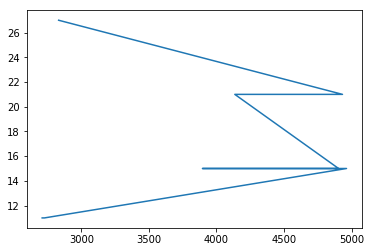

In [4]:
fileName="ex1"
#if testFromFile(filename) == 0:
fileName = testDir+fileName
bigFunction(fileName)